![maat logo](maat_lowres_little.png)

# Maât Academy : The Water System

Load the Maât component for system design

In [1]:
from maat.systemdefinition import *

## Design of the system
The goal of this is to provide water for animals. It contains two automata, a pump and a dispenser fitted with a sensor.

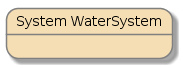

In [2]:
system = System("WaterSystem")

show(system)

### The Dispenser
The Dispenser is informed by the sensor (modeled by a simulated input) of it’s current level of water. If the
water is lower than a certain amount (constant parameter LVLMIN), the dispenser will send a "request" signal.
And it will ask for an amount of water equals to (LVLRECO - lvl) where "LVLRECO" is a constant parameter giving the recommended level and "lvl" is a variable giving the current level.
When the pump is pumping into the dispenser we want to block the possibility of another request of water in
order to have a stable system. As a consequence we also need to know about the current state of the pump.

#### States

The behavior of the Dispenser can be modeled as a state-machine which discriminate into "states" the different sets of possible behaviors. Here we can discriminate three states :
* `full` where the dispenser is only listening to the sensor and doing nothing else
* `checking` where the dispenser has been updated on the value of `level` and checks whether or not it needs a refill
* `refilling` where the dispenser waits for the pump to finish the request it has been asked

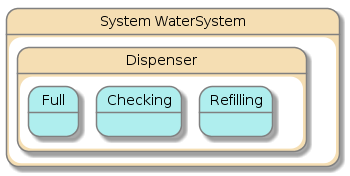

In [3]:
dispenser = system.addStateMachine("Dispenser")

full      = dispenser.addState("Full")
checking  = dispenser.addState("Checking")
refilling = dispenser.addState("Refilling")

show(system)

#### Attributes

We can therefore model this dispenser as having four attributes :
* `LVLMIN` that is a CONSTANT corresponding to the minimal level of water that is acceptable
* `LVLRECO` that is a CONSTANT corresponding to the recommended level of water
* `level` that is a value updated by the sensor and reports the current level of water
* `isclosed` that is a boolean value updated by the pump and that informs whether or not the pump is closed

In [4]:
LVLMIN  = dispenser.addIntConst("LVLMIN", 4)
LVLRECO = dispenser.addIntConst("LVLRECO", 10)
level    = dispenser.addIntVar("level")
isclosed = dispenser.addBoolVar("isclosed")

#### Communication ports

This object must also have three communication channels or "ports" :
* `sensor`, by which the sensor (not modeled but simulated by inputs to the system) informs the dispenser of the current level of water : "lvl" variable
* `request` by which the dispenser asks the pump for a refill : if `level` smaller than `LVLMIN` the asked quantity is `LVLRECO - level` so that after the pumping `level` equals `LVLRECO`
* `closed` by which the pump informs the dispenser of it’s current state (active or inactive) through updating the `isclosed` variable

In [5]:
disp_sensor = dispenser.addInPort("sensor", ["int"])
disp_closed = dispenser.addInPort("closed", ["bool"])
disp_request = dispenser.addOutPort("request", ["int"])

#### Transitions between states

Now we add the possible transitions between these states define their associated behavior. We also add an initial state to properly start the system.

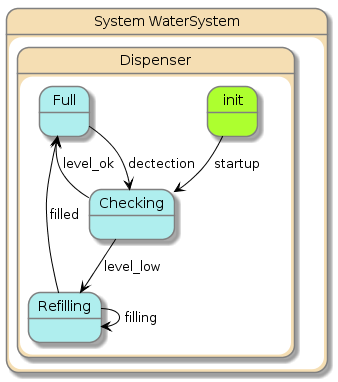

In [6]:
init = dispenser.addInitialState("init")

startup = init.addTransition("startup", checking)

level_ok  = checking.addTransition("level_ok", full)
level_low = checking.addTransition("level_low", refilling)

filling = refilling.addTransition("filling", refilling)
filled  = refilling.addTransition("filled", full)

detection = full.addTransition("dectection", checking)

show(system)

Than we  add detailed behaviors to the transition :

The `detection` transition shall be triggered when receiving "level" input from its `sensor` port:

In [7]:
detection.addReceive(disp_sensor, ["level"])

True

The `level_ok` transition shall be triggered only if level > LVLMIN. This condition is expressed by the means of the guard concept :

In [8]:
level_ok.addGuard("level > LVLMIN")

True

The `level_low` transition shall be triggered only if level <= LVLMIN. When it triggered it shall request the difference between the recommanded level of water and the current level.

In [9]:
level_low.addGuard("level <= LVLMIN")
level_low.addSend(disp_request, ["LVLRECO - level"])

True

The `filling` transition shall be triggered only when the pump is open, namely when receiving `c` input from its `closed` port, but only if c egals to 0:

In [10]:
filling.addReceive(disp_closed, ["isclosed"])
filling.addGuard("isclosed == false")

True

The `filled` transition shall be triggered only when the pump is closed, namely when receiving `c` input from its `closed` port, but only if c egals to 1:

In [11]:
filled.addReceive(disp_closed, ["isclosed"])
filled.addGuard("isclosed == true")

True

### The Pump
The Pump is listening to "request" signals from the Dispenser. If it receives one, it will store the requested amount, stop listening for request and pump with a fixed flow rate "FLOW" until the required amount is reached. When it is reached, the pump will resume listening to the Dispenser.

#### States

The associated state-machine can be modeled with two states:
* `inactive` where the Pump is listening and not pumping
* `active` where the Pump is not listening and pumping

We also add an initial state to properly start the system.

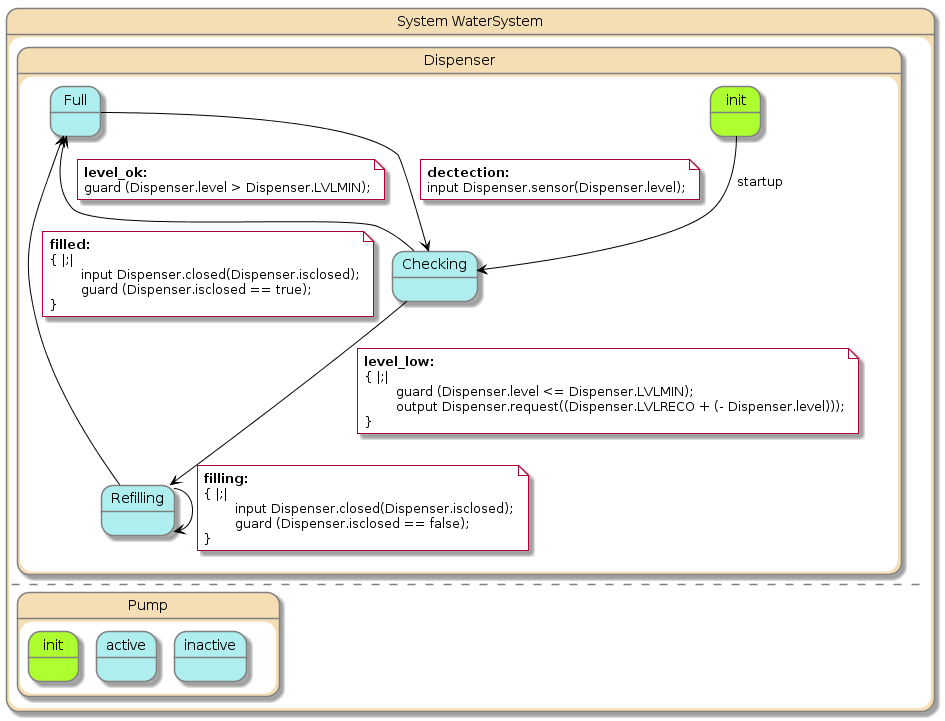

In [12]:
pump = system.addStateMachine("Pump")

init = pump.addInitialState("init")
active = pump.addState("active")
inactive = pump.addState("inactive")

show(system)

#### Attributes

Therefore we can model the Pump with two attributes:
* "FLOW" that corresponds to the flow rate of the pump
* "quantity" that is a value (given through the request port) which corresponds to the quantity of water asked by the dispenser

In [13]:
FLOW = pump.addIntConst("FLOW", 10)
quantity = pump.addIntVar("quantity")

#### Communications ports

The Pump object must also have two ports :
* `request` by which the dispenser asks the pump for a refill
* `closed` by which the pump informs the dispenser of it’s current state (active or inactive)

In [14]:
pump_request = pump.addInPort("request", ["int"])
pump_closed = pump.addOutPort("closed", ["bool"])

#### Transitions between states

For the Pump state-machine, the transitions are defined and explained in the following.

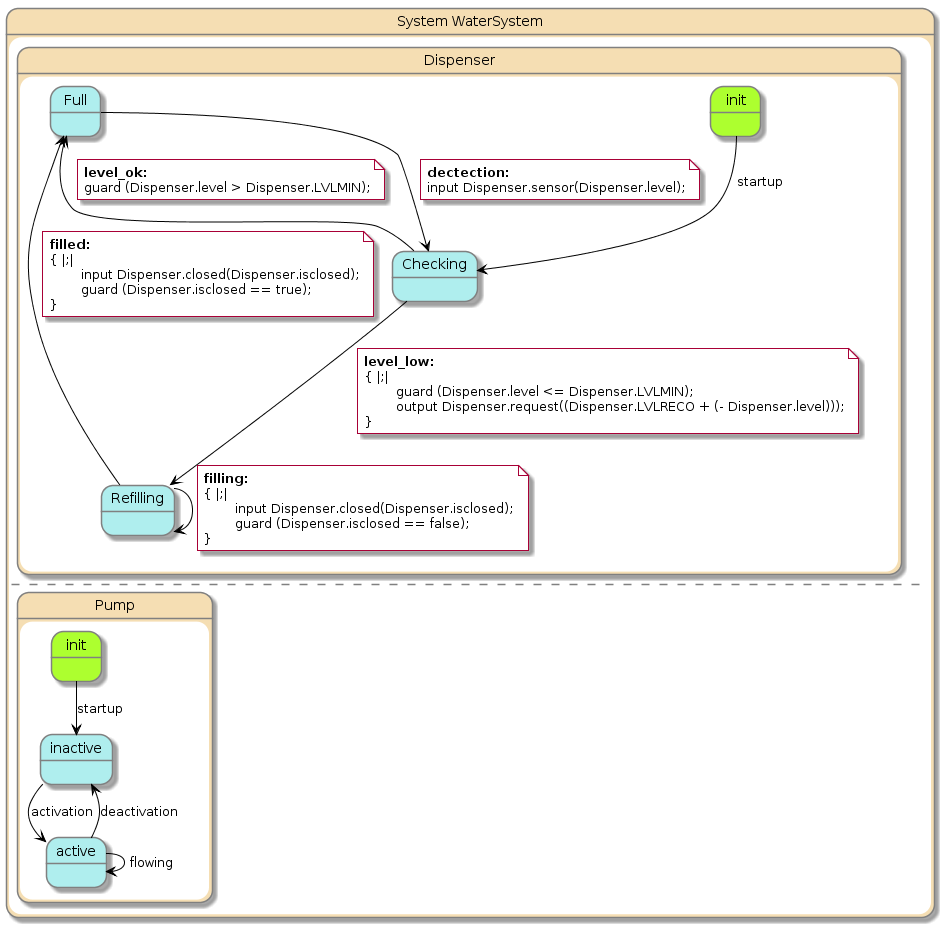

In [15]:
startup = init.addTransition("startup", inactive)
activation = inactive.addTransition("activation", active)
flowing = active.addTransition("flowing", active)
deactivation = active.addTransition("deactivation", inactive)
show(system)

Hereafter are the detailed behaviors associated with the Pump transitions. The `activation` transition shall be triggered when receiving data on its `pump_request` port and shall store these data in its `quantity` attibute.

In [16]:
activation.addReceive(pump_request, ["quantity"])

True

The `flowing` transition shall be triggered only if `quantity` is striclty positive. It shall also indicate the pump is on by sending 0 on its `closed` communication port. Finally, the `quantity` attribute shall be updated to take into account the amount of water that have been sent.

In [17]:
flowing.addGuard("quantity > 0")
flowing.addSend(pump_closed, ["false"])
flowing.addStatement("quantity := quantity - FLOW")

True

The `deactivation` transition shall be trigerred when the requested quantity of water have been sent, that is to say when `quantity` is equal to 0 (or less, in any case case we reset `quantity` to 0). It shall also indicate the pump is off by sending 1 on its `closed` communication port.

In [18]:
deactivation.addGuard("quantity <= 0")
deactivation.addStatement("quantity := 0")
deactivation.addSend(pump_closed, ["true"])

True

### Connecting the Pump to the Dispenser and the Dispensor to the environment

We now connect the associated ports of each component. We choose a 'Rendez-Vous' connexion.

In [19]:
system.connectRdv(pump_closed, disp_closed)
system.connectRdv(pump_request, disp_request)

Input on the input port `sensor` of the Dispenser will be simulated by a connexion to the environnement.

In [20]:
system.connectEnv(disp_sensor)

This is how the full system looks like : 

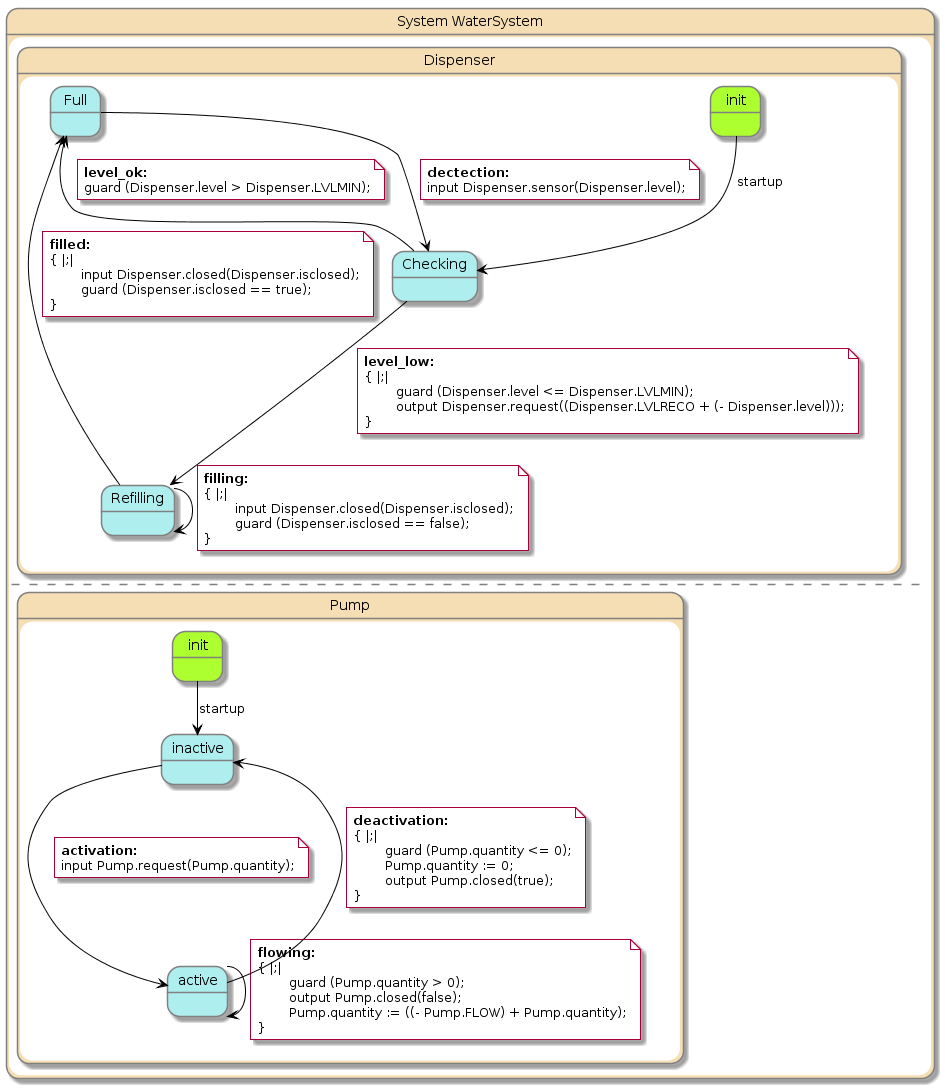

In [21]:
show(system)

##  Model Execution Exploration

### Import Configuration module

In [22]:
from maat.configuration import * 

Maat Analysis rely on the exploration of possible executions of the system. This exploration generates a tree structure of *execution contexts* that represent the explored executions. This exploration is performed by an `Engine` that is initialized with a `Configuration`.
In this section we present how to use these objects to explore possible executions on the WaterSystem model.


### Configuration of the Exploration

We build a `Configuration` and set its analysis type to "exploration".

In [23]:
explorationConfiguration = Configuration()
explorationConfiguration.setAnalysisType('exploration')

Since the model contains loop, as it is often the case in interesting systems, we shall specify end conditions for the exploration in order to avoid the exploration to run forever. For example we can limit the maximum number of execution context to evaluate with following line

In [24]:
explorationConfiguration.setSymbexLimits(step=10);

We can also configure how to explore the execution tree  (example : BFS /DFS )

In [25]:
explorationConfiguration.setStrategy('BFS')

### Exploration Launch 

`Engine` are in charge of running the exploration. They are created from a previously made `Configuration`.
In the following cell, we create an Engine, then we specify on which model to run the analysis and finaly, we launch the analysis. We store the analysis result in a variable.

In [26]:
explorationEngine = Engine(explorationConfiguration)
explorationEngine.setSystem(system)
explorationResult = explorationEngine.start()

Configuration successfully loaded
System successfully loaded.


### Viewing the result 

We can visualize the execution tree. 

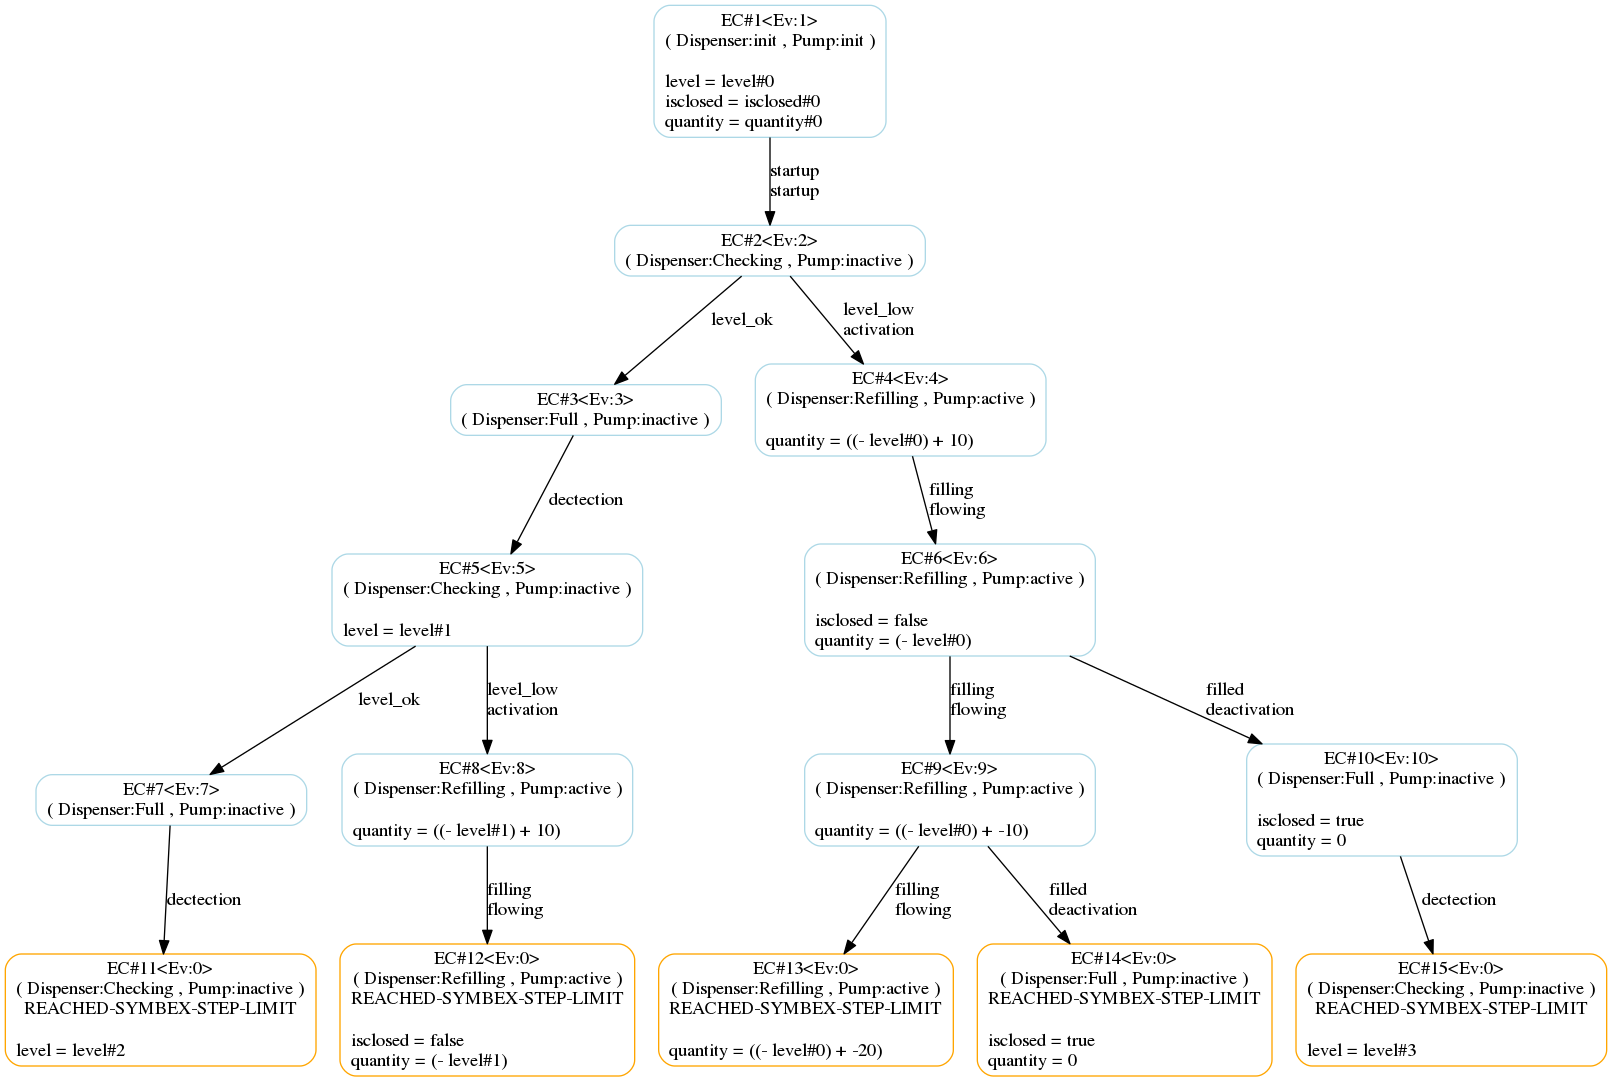

In [27]:
show(explorationResult, showCommunication=False, showAssign=True, showTransition=True)

## Design Validation

Design Validation aims to verify that the model of the system is correct. In this section we will show how to configure the analyse in order to check wether all transitions of the system can be reached.

### Configuration

We create a configuration object that is used to define which analyse to perform. We set the analysis type to 'transition_coverage'.

In [28]:
c1 = Configuration()
c1.setAnalysisType('transition_coverage')

### Analysis

Engine are created in the same way as for Execution Exploration.
In the following cell, we create an Engine, then we specify on which model to run the analysis and finaly, we launch the analysis. We store the analysis result in a variable.

In [29]:
from maat.designvalidation import *
engine1 = Engine(c1)
engine1.setSystem(system)
result = engine1.start()

Configuration successfully loaded
System successfully loaded.


### Exploit the result

Now that the analysis has been performed, we can verify wether all transition have been covered.

In [30]:
print(result.report())

REPORT
	SUPERVISOR  PROCESSOR
	TRANSITION COVERAGE PROCESSOR
		All the << 10 >> transitions are covered !
		Number of nodes cut back: 1



We can also display the execution tree to see in detail at which path allows to cover which transitions.

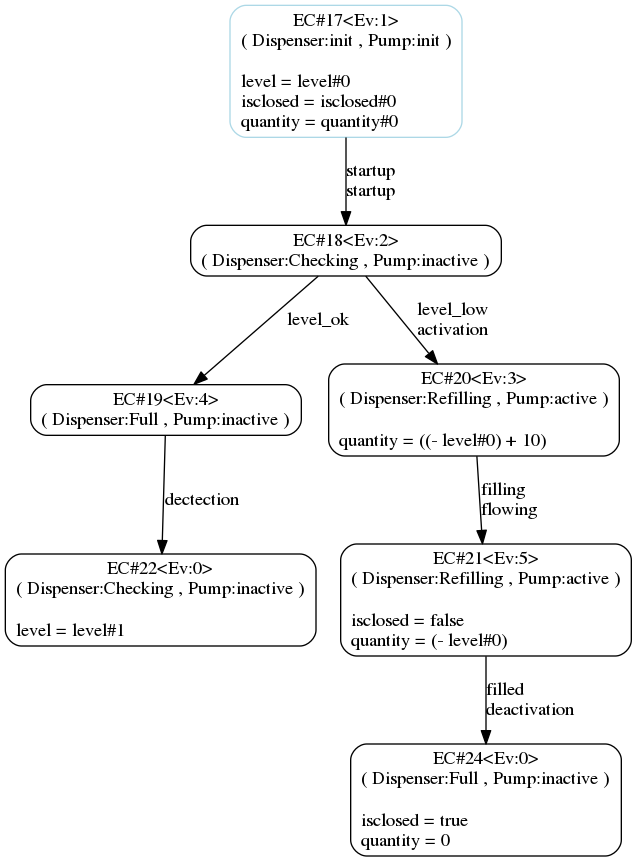

In [31]:
show(result, showCommunication=False, showAssign=True, showTransition=True)

We can also display the various path of the execution tree as sequence diagrams in order to focus on communications viewing.

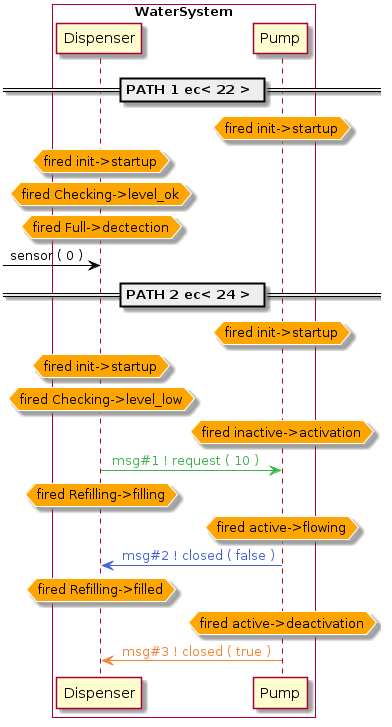

In [32]:
showSD(result, showAssign=False, showTransition=True, enabledNumerization=True)

We can also display the communications in a (configurable) textual format that will be interesting for the System Compliance use case.

In [33]:
print( showText(result, showTransition=False, enabledNumerization=True) )

TRACE NUMBER 1
	input#env  Full->sensor( 0 )

TRACE NUMBER 2
	output#rdv Checking->request( 10 )
	input#rdv  inactive->request( 10 )
	input#rdv  Refilling->closed( false )
	output#rdv active->closed( false )
	input#rdv  Refilling->closed( true )
	output#rdv active->closed( true )




### Example on non conform system

We first build a system in which some transition are not reachable which seems unlikely to be a desirable feature.
This faulty system is built by `createSystem_Faulty()` method. 
The flaw is introduced by modifying the `filling` guard to `filling.addGuard("isclosed == true")`.
Then we launche a new analysis 'transition_coverage' on this new system.

In [34]:
engine2 = Engine(c1)
from watersystem import createSystem_Faulty
system_ko = createSystem_Faulty()
engine2.setSystem(system_ko)
result = engine2.start()

Configuration successfully loaded
System successfully loaded.


Looking at the result, we can view the 4 transitions that are not covered

In [35]:
print(result.report())

REPORT
	SUPERVISOR  PROCESSOR

		The DEADLOCK found : 14
	TRANSITION COVERAGE PROCESSOR
		Results: << 6 on 10 >> are covered !
		List of the << 4 >> transitions non covered:

			transition filling : Refilling --> Refilling
			transition filled : Refilling --> Full

			transition flowing : active --> active
			transition deactivation : active --> inactive

		Results: << 6 on 10 >> are covered !
		Number of nodes cut back: 38



And the Execution tree views gives more insight! Indeed, this faulty system reach a deadlock context where the Dispenser is in Refilling state, and the Pump is active. The filling transition cannot be drawned because of its modified guard.  

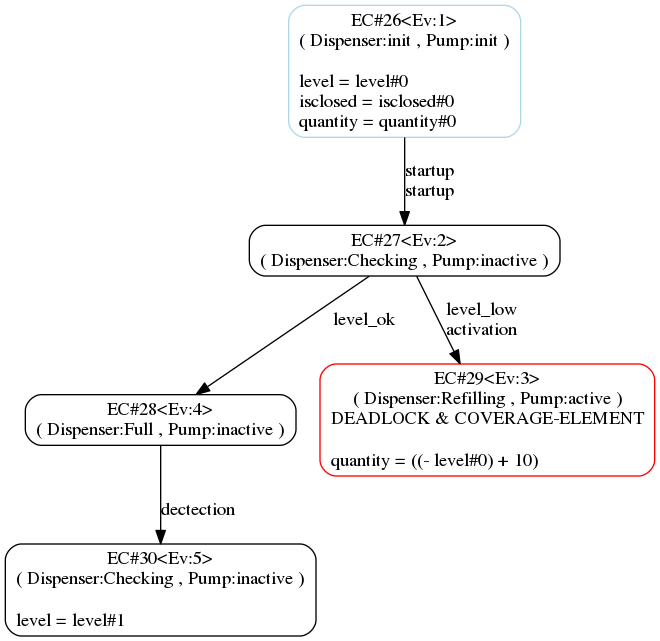

In [36]:
show(result, showCommunication=False, showAssign=True, showTransition=True)

### (Incoming) Model Checking

## System Compliance

In this section we present a use case to verify that some implantation of the water system is conform to the designed model. 
In this use case, we suppose that we have in our possession a trace that containes all the communications performed on the system.This trace is stored in the file *waterSystem_ok.trace* in a (configurable) textual format (similar to the one displayed in section 4.3). We want to check that this trace can be produced by a implementation of the water system that is a conform to the model.

### Configuration

For this analysis, we create a new configuration, of type 'trace_compliance'.
We also must give in the configuration the name of the file that contain the trace of execution of the system.

In [37]:
c2 = Configuration()
c2.setAnalysisType('trace_compliance')
c2.setTraceFile("waterSystem_ok.trace") # Faire les deux cas
c2.check()

Configuration check:  all ok.


### Analysis

Then the analysis is launched in the same way as for design validation.

In [38]:
from maat.systemcompliance import *
engine3 = Engine(c2)
engine3.setSystem(system)
result = engine3.start()

Configuration successfully loaded
System successfully loaded.


### Exploit the result

The analysis report, by exhibiting a pass verdict claims that the trace is conform to the model.

In [39]:
print(result.report())

REPORT
	SUPERVISOR  PROCESSOR
	AVM OFF-LINE TEST  PROCESSOR
	============================  THE VERDICT IS : PASS  ===========================



And if we look at the execution tree, it indeed display a path exhibiting the communication specified by the trace. This path ends with a green surrounded node.

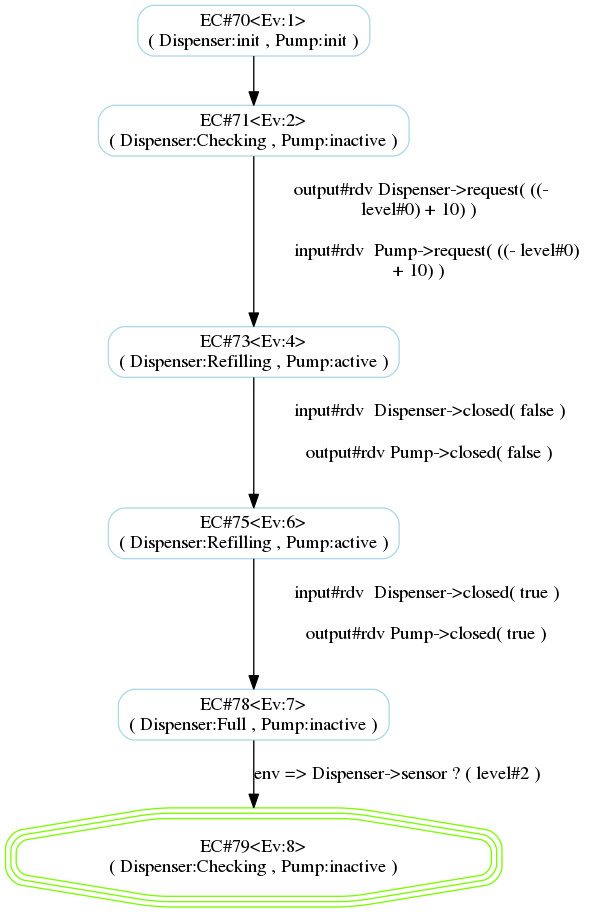

In [40]:
show(result, showCommunication=True, showAssign=False, showTransition=False)

### With faulty trace

If we give a trace that cannot be produced by the system, for example by adding a request signal before the pump is closed, the analysis shall show the trace is not conform by displaying a fail verdict in the report

In [41]:
c3 = Configuration()
c3.setAnalysisType('trace_compliance')
c3.setTraceFile("waterSystem_faulty.trace") # Faire les deux cas
c3.check()
engine4 = Engine(c3)
engine4.setSystem(system)
result = engine4.start()
print(result.report())

Configuration check:  all ok.
Configuration successfully loaded
System successfully loaded.
REPORT
	SUPERVISOR  PROCESSOR
	AVM OFF-LINE TEST  PROCESSOR
	============================  THE VERDICT IS : FAIL  ===========================
The smallest trace that have failed started with :
	trace#0< size: 9 > { |;|
		tpid#5 com:output inst::WaterSystem.Dispenser.request{ 10 }
		tpid#6 com:input inst::WaterSystem.Pump.request{ 10 }
		tpid#7 com:input inst::WaterSystem.Dispenser.closed{ true }
		tpid#8 com:output inst::WaterSystem.Pump.closed{ true }
	}



Moreover, the report specify at which point the trace cannot be compliant anymore.

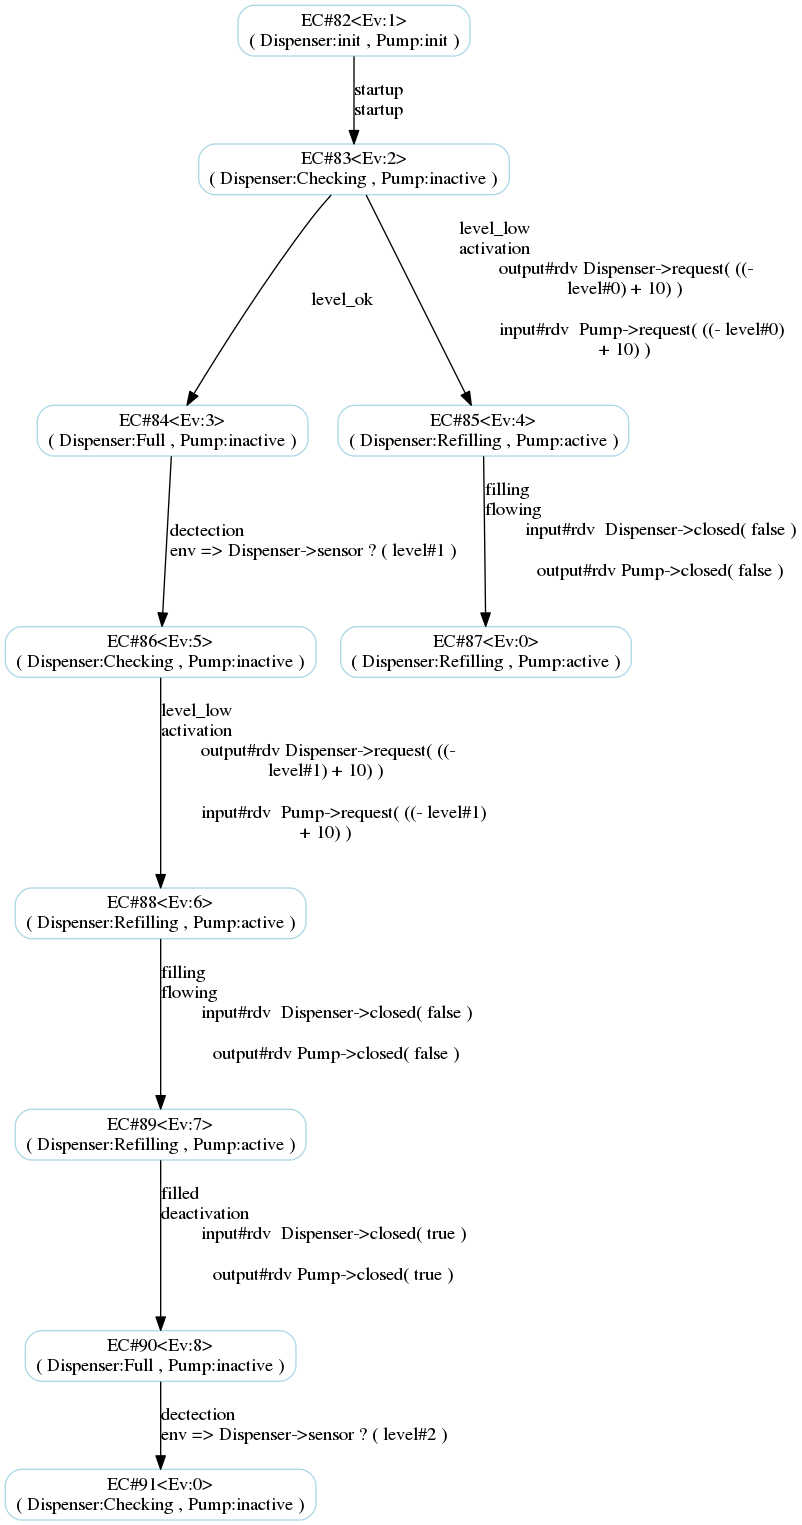

In [42]:
show(result, showCommunication=True, showAssign=False, showTransition=True)